In [1]:
import itertools
import re
from io import StringIO
from pathlib import Path

from IPython.display import display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

/usr/local/lib/python3.13/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/usr/lib/python3/dist-packages/pytz/__init__.py:31: SyntaxWarning: invalid escape sequence '\s'
  match = re.match("^#\s*version\s*([0-9a-z]*)\s*$", line)


In [ ]:
LOG_FILE_PATHNAME = "../logs/benchmark_results.log"
OUTPUT_DIR = "../output"

In [3]:
def parse_log_to_dataframe(path: str) -> tuple[int, dict[str, pd.DataFrame]]:
    initial_capacity_log2 = 0

    with Path(path).open(encoding="utf-8") as log_file:
        lines = log_file.readlines()
    for i, line in enumerate(lines):
        lines[i] = re.sub(
            r"\[\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\.\d{3}\] \[[a-zA-Z]+\] ", "", line
        ).strip()

    dataframes = {}

    i = 0
    while i < len(lines):
        line = lines[i]

        if line.endswith(":"):
            category = line[:-1]

            table_lines: list[str] = []

            # Header
            i += 1
            line = lines[i]
            table_lines.append(line.replace("DFF_FG", "DFF(FG)"))
            i += 1
            line = lines[i]

            # Data
            while len(line) > 0 and line[0].isnumeric():
                if (match := re.match(r"2\^(\d+) \* \d+ \(\d+\)", line)) is not None:
                    initial_capacity_log2 = int(match.group(1))
                line = re.sub(
                    r"2\^" + str(initial_capacity_log2) + r" \* \d+ \((\d+)\)",
                    r"\1",
                    line,
                )
                table_lines.append(line)
                i += 1
                if i >= len(lines):
                    break
                line = lines[i]

            first_column_width = max(
                len(line) - len(line.split(maxsplit=1)[1]) for line in table_lines[1:]
            )
            table_lines[0] = (
                table_lines[0].split(maxsplit=1)[0] + " " * first_column_width
            )[:first_column_width] + table_lines[0].split(maxsplit=1)[1]
            for j in range(1, len(table_lines)):
                table_lines[j] = (
                    table_lines[j].split(maxsplit=1)[0] + " " * first_column_width
                )[:first_column_width] + table_lines[j].split(maxsplit=1)[1]

            df = pd.read_fwf(StringIO("\n".join(table_lines))).replace(0, np.nan)
            dataframes[category] = df

            continue

        i += 1

    return initial_capacity_log2, dataframes

In [4]:
def save_to_csv(dataframes: dict[str, pd.DataFrame], output_dir: str | Path):
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    for category, df in dataframes.items():
        name = re.sub(r'["]', "", re.sub(r"[/:]", "_", category))
        df.to_csv(Path(output_dir) / f"{name}.csv", index=False)

In [5]:
initial_capacity_log2, data = parse_log_to_dataframe(LOG_FILE_PATHNAME)
save_to_csv(data, Path(OUTPUT_DIR) / "data")

In [6]:
def draw_line_chart(
    axe,
    df: pd.DataFrame,
    /,
    *,
    xlabel: str,
    ylabel: str,
    yscale: str = "linear",
    title: str = "",
    draw_legend: bool = True,
):
    markers = itertools.cycle(["o", "s", "D", "^", "v", "<", ">", "p"])

    axe.set_xlabel(xlabel)
    axe.set_ylabel(ylabel)
    axe.set_yscale(yscale)
    if title:
        axe.set_title(title)

    for column in df.columns[1:]:
        axe.plot(
            df["Elements"] / (2**initial_capacity_log2),
            df[column],
            label=column,
            marker=next(markers),
            linestyle="-",
        )

    axe.spines["top"].set_linewidth(1.5)
    axe.spines["left"].set_linewidth(1.5)
    axe.spines["bottom"].set_linewidth(1.5)
    axe.spines["right"].set_linewidth(1.5)

    axe.grid(True, linestyle=":", linewidth=1)

    axe.set_xticks(df["Elements"] / (2**initial_capacity_log2))

    ymin, ymax = axe.get_ylim()
    if yscale == "log":
        log_ymin = np.log10(ymin)
        log_ymax = np.log10(ymax)
        log_padding = (log_ymax - log_ymin) * 0.2
        axe.set_ylim(10**log_ymin, 10 ** (log_ymax + log_padding))
    else:
        top_padding = (ymax - ymin) * 0.2
        axe.set_ylim(ymin, ymax + top_padding)

    if draw_legend:
        legend = axe.legend(
            ncol=2,
            frameon=True,
            fancybox=True,
            framealpha=0.9,
        )
        legend.get_frame().set_edgecolor("gray")
        legend.set_zorder(0)


def save_line_chart(
    df: pd.DataFrame,
    output_path: str | Path,
    /,
    *,
    xlabel: str,
    ylabel: str,
    yscale: str = "linear",
):
    Path(output_path).parent.mkdir(parents=True, exist_ok=True)

    original_font_family = mpl.rcParams["font.family"]
    original_font_size = mpl.rcParams["font.size"]
    original_mathtext_fontset = mpl.rcParams["mathtext.fontset"]
    original_mathtext_rm = mpl.rcParams["mathtext.rm"]
    mpl.rcParams["font.family"] = "Times New Roman"
    mpl.rcParams["font.size"] = 22
    mpl.rcParams["mathtext.fontset"] = "custom"
    mpl.rcParams["mathtext.rm"] = "Times New Roman"

    fig, axe = plt.subplots()
    draw_line_chart(
        axe, df, xlabel=xlabel, ylabel=ylabel, yscale=yscale, draw_legend=False
    )
    lines = axe.get_lines()
    for line in lines:
        line.set_linewidth(3)
        line.set_markersize(12)
    legend = axe.legend(
        ncol=2,
        frameon=True,
        fancybox=True,
        framealpha=0.9,
        handletextpad=0.5,
        labelspacing=0.2,
        columnspacing=0.8,
        fontsize=18,
    )
    legend.get_frame().set_edgecolor("gray")
    legend.set_zorder(0)
    fig.tight_layout()

    mpl.set_loglevel("error")
    fig.savefig(output_path.with_suffix(".eps"), format="eps", bbox_inches="tight")
    mpl.set_loglevel("notset")

    mpl.rcParams["font.family"] = original_font_family
    mpl.rcParams["font.size"] = original_font_size
    mpl.rcParams["mathtext.fontset"] = original_mathtext_fontset
    mpl.rcParams["mathtext.rm"] = original_mathtext_rm

    plt.close(fig)

In [7]:
def draw_bar_chart(
    axe,
    df: pd.DataFrame,
    /,
    *,
    ylabel: str,
    title: str = "",
    labels: list[str] | None = None,
    draw_legend: bool = True,
):
    axe.set_ylabel(ylabel)
    if title:
        axe.set_title(title)

    for column in df.columns[1:]:
        df[column] = pd.to_numeric(df[column], errors="coerce")

    categories = df.columns[1:]
    x = np.arange(len(categories))

    bar_width = 0.35

    for i in range(len(df)):
        axe.bar(
            x + (i - 0.5) * bar_width,
            df.iloc[i, 1:].values,
            bar_width,
            label=labels[i] if labels else format(df.iloc[i, 0], ","),
            edgecolor="black",
        )

    axe.set_xticks(x)
    axe.set_xticklabels(categories)

    axe.spines["top"].set_linewidth(1.5)
    axe.spines["left"].set_linewidth(1.5)
    axe.spines["bottom"].set_linewidth(1.5)
    axe.spines["right"].set_linewidth(1.5)

    axe.grid(True, linestyle=":", linewidth=1)

    if draw_legend and len(df) > 1:
        legend = axe.legend(
            frameon=True,
            fancybox=True,
            framealpha=0.9,
        )
        legend.get_frame().set_edgecolor("gray")
        legend.set_zorder(0)


def save_bar_chart(
    df: pd.DataFrame,
    output_path: str | Path,
    /,
    *,
    ylabel: str,
    labels: list[str] | None = None,
):
    Path(output_path).parent.mkdir(parents=True, exist_ok=True)

    original_font_family = mpl.rcParams["font.family"]
    original_font_size = mpl.rcParams["font.size"]
    original_mathtext_fontset = mpl.rcParams["mathtext.fontset"]
    original_mathtext_rm = mpl.rcParams["mathtext.rm"]
    mpl.rcParams["font.family"] = "Times New Roman"
    mpl.rcParams["font.size"] = 22
    mpl.rcParams["mathtext.fontset"] = "custom"
    mpl.rcParams["mathtext.rm"] = "Times New Roman"

    fig, axe = plt.subplots()
    draw_bar_chart(axe, df, ylabel=ylabel, labels=labels, draw_legend=False)
    axe.set_xticklabels(
        axe.get_xticklabels(),
        rotation=-30,
        ha="left",
        rotation_mode="anchor",
        fontsize=20,
    )
    if len(df) > 1:
        legend = axe.legend(
            frameon=True,
            fancybox=True,
            framealpha=0.9,
            handletextpad=0.5,
            labelspacing=0.2,
            columnspacing=0.8,
            fontsize=18,
        )
        legend.get_frame().set_edgecolor("gray")
        legend.set_zorder(0)
    fig.tight_layout()

    mpl.set_loglevel("error")
    fig.savefig(output_path.with_suffix(".eps"), format="eps", bbox_inches="tight")
    mpl.set_loglevel("notset")

    mpl.rcParams["font.family"] = original_font_family
    mpl.rcParams["font.size"] = original_font_size
    mpl.rcParams["mathtext.fontset"] = original_mathtext_fontset
    mpl.rcParams["mathtext.rm"] = original_mathtext_rm

    plt.close(fig)

In [8]:
def generate_benchmark_ratio(data: pd.DataFrame) -> pd.DataFrame:
    # Two rows, DFF and DFF(FG), other columns are used as the columns (baselines)
    # show ratio of DFF results / each baseline
    df = pd.DataFrame(index=["DFF", "DFF(FG)"], columns=data.columns[3:])
    for column in df.columns:
        df.loc["DFF", column] = (
            data.loc[:, "DFF"].sum() / data.loc[:, column].sum()
        ) - 1
        df.loc["DFF(FG)", column] = (
            data.loc[:, "DFF(FG)"].sum() / data.loc[:, column].sum()
        ) - 1
    return df

In [9]:
FIGURE_DIR = Path(OUTPUT_DIR) / "figures"

Improvement ratio of DFF(B) and DFF(F) over each baseline


IFF       BBF        EBF      LDCF        DCF  \
insertion      DFF      1.867648  0.153978  53.935667  0.796016   0.271921   
               DFF(FG)  1.810756  0.131084   52.84579  0.760385   0.246687   
positive_query DFF      0.518386  0.950684    8.86166  1.657082   6.780043   
               DFF(FG)  0.223065  0.571283     6.9436  1.140288   5.266851   
negative_query DFF      2.003275  2.302064   4.943114    4.2272  26.013092   
               DFF(FG)  0.463563   0.60917   1.896212  1.547332  12.164085   
deletion       DFF      0.339037  -0.01918  38.780602  0.939979    6.46948   
               DFF(FG)  0.089364 -0.202062  31.363211  0.578255    5.07674   

                              DBF  
insertion      DFF      -0.112166  
               DFF(FG)   -0.12978  
positive_query DFF       8.683535  
               DFF(FG)   6.800119  
negative_query DFF      24.716867  
               DFF(FG)  11.532405  
deletion       DFF       8.730366  
               DFF(FG)   6.916067

IFF       BBF  EBF      LDCF  \
total_insertion_time      DFF     -0.628586 -0.161624 -1.0 -0.434067   
                          DFF(FG) -0.619216 -0.140476 -1.0  -0.41979   
total_positive_query_time DFF     -0.328289 -0.471825 -1.0  -0.61152   
                          DFF(FG) -0.156783 -0.336968 -1.0 -0.512331   
total_negative_query_time DFF     -0.655162 -0.690113 -1.0 -0.800253   
                          DFF(FG) -0.283093 -0.355754 -1.0 -0.584733   
total_deletion_time       DFF     -0.232498  0.002732 -1.0 -0.467826   
                          DFF(FG) -0.071034  0.213682 -1.0 -0.355869   

                                        DCF       DBF  
total_insertion_time      DFF     -0.377367  0.244189  
                          DFF(FG)  -0.36166  0.275574  
total_positive_query_time DFF     -0.921927 -0.932811  
                          DFF(FG) -0.901993 -0.915656  
total_negative_query_time DFF     -0.979376 -0.977923  
                          DFF(FG) -0.957123 -0.954103  
total_deletion_time       DFF     -0.925218 -0.935733  
                          DFF(FG) -0.909486 -0.922213

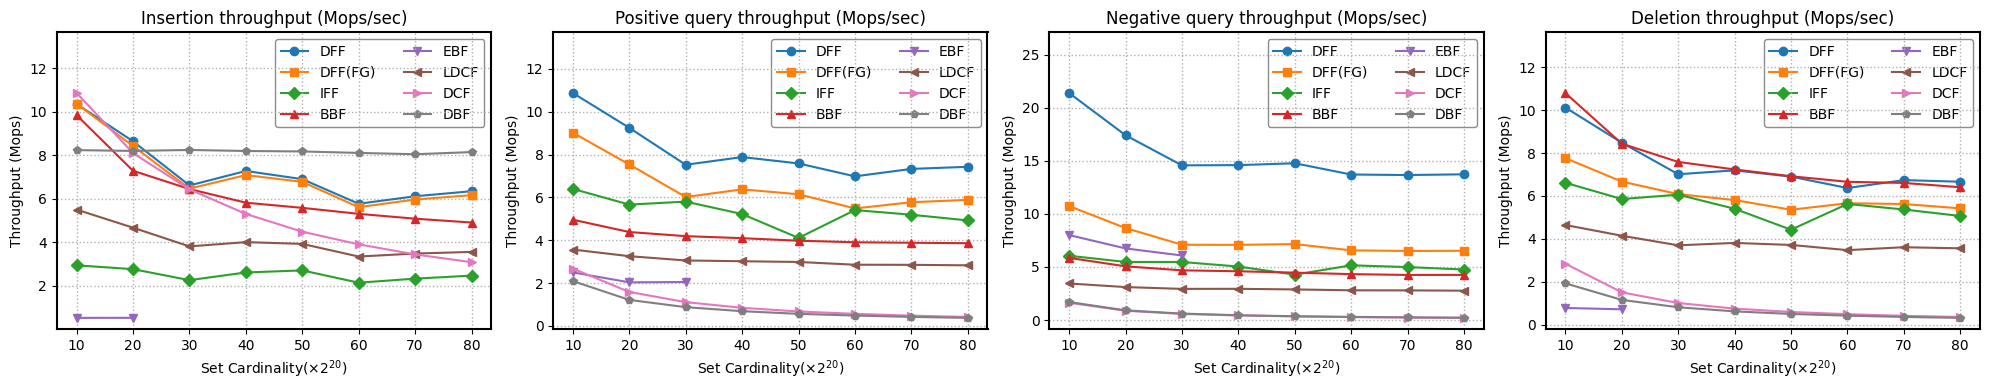

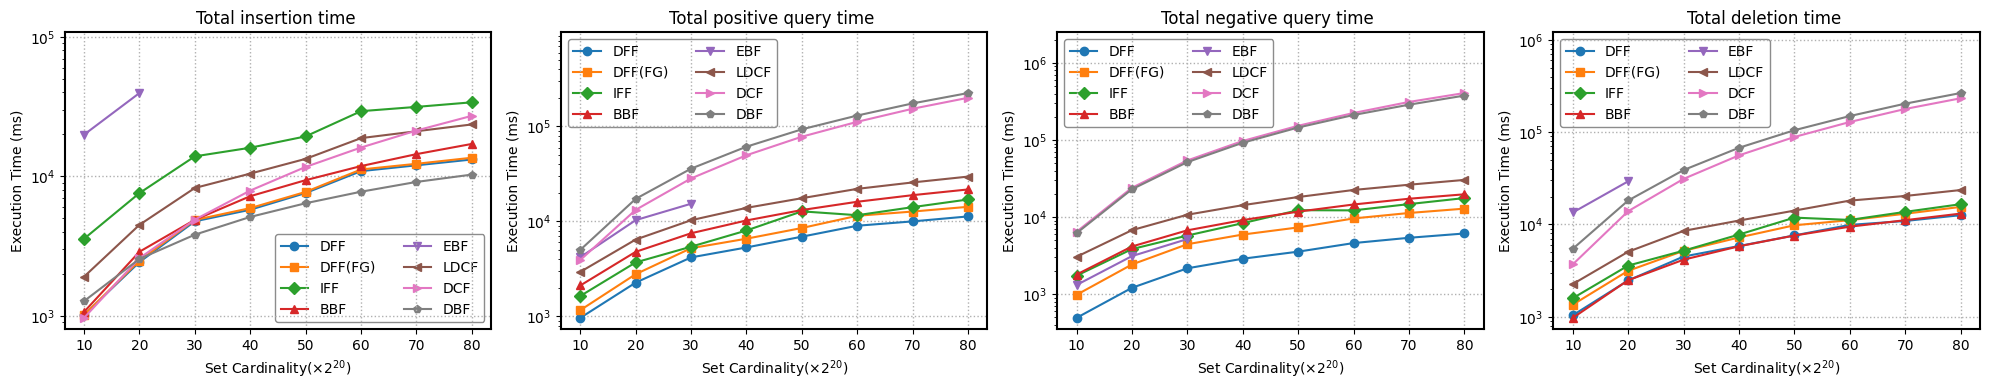

In [10]:
# Operations throughput
xlabel = "Set Cardinality($\\times2^{" + str(initial_capacity_log2) + "}$)"
ylabel = "Throughput (Mops)"
filenames = [
    "insertion_throughput",
    "positive_query_throughput",
    "negative_query_throughput",
    "deletion_throughput",
]

fig, axes = plt.subplots(1, 4, figsize=(20, 4))
for i, (category, df) in enumerate(tuple(data.items())[:8:2]):
    axe = axes[i]
    draw_line_chart(
        axe,
        df,
        xlabel=xlabel,
        ylabel=ylabel,
        title=category.replace("(Mops)", "").strip(),
    )
    save_line_chart(df, FIGURE_DIR / filenames[i], xlabel=xlabel, ylabel=ylabel)

fig.tight_layout()
fig.show()

# Operations total time
xlabel = "Set Cardinality($\\times2^{" + str(initial_capacity_log2) + "}$)"
ylabel = "Execution Time (ms)"
filenames = [
    "total_insertion_time",
    "total_positive_query_time",
    "total_negative_query_time",
    "total_deletion_time",
]

fig, axes = plt.subplots(1, 4, figsize=(20, 4))
for i, (category, df) in enumerate(tuple(data.items())[1:9:2]):
    axe = axes[i]
    draw_line_chart(
        axe,
        df,
        xlabel=xlabel,
        ylabel=ylabel,
        yscale="log",
        title="Total " + re.sub(r" total|\(ms\)", "", category).lower(),
    )
    save_line_chart(
        df, FIGURE_DIR / filenames[i], xlabel=xlabel, ylabel=ylabel, yscale="log"
    )

fig.tight_layout()
fig.show()

print("Improvement ratio of DFF(B) and DFF(F) over each baseline")
display(
    pd.concat(
        (generate_benchmark_ratio(df) for df in tuple(data.values())[:8:2]),
        keys=(
            "insertion",
            "positive_query",
            "negative_query",
            "deletion",
        ),
    )
)
display(
    pd.concat(
        (generate_benchmark_ratio(df) for df in tuple(data.values())[1:9:2]),
        keys=(
            "total_insertion_time",
            "total_positive_query_time",
            "total_negative_query_time",
            "total_deletion_time",
        ),
    )
)

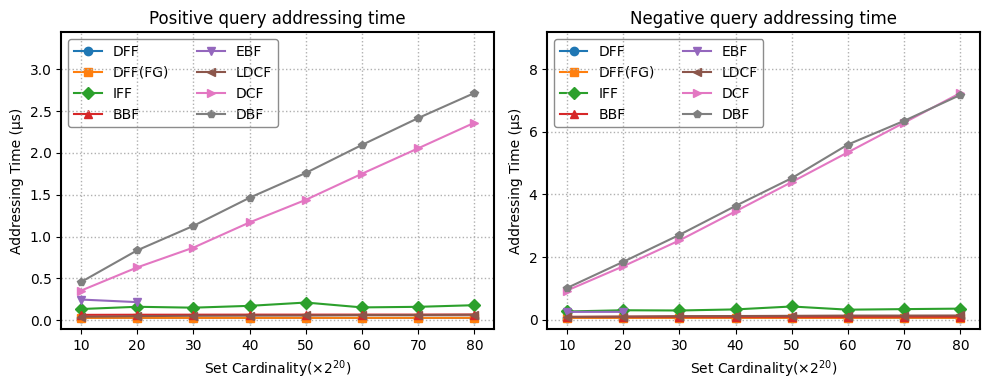

In [11]:
# Addressing time
xlabel = "Set Cardinality($\\times2^{" + str(initial_capacity_log2) + "}$)"
ylabel = "Addressing Time (μs)"
filenames = [
    "positive_query_addressing_time",
    "negative_query_addressing_time",
]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for i, (category, df) in enumerate(list(data.items())[8:10]):
    axe = axes[i]
    draw_line_chart(
        axe,
        df,
        xlabel=xlabel,
        ylabel=ylabel,
        title=category.replace(" (μs)", "").capitalize(),
    )
    save_line_chart(df, FIGURE_DIR / filenames[i], xlabel=xlabel, ylabel=ylabel)

fig.tight_layout()
fig.show()

Improvement ratio of DFF(B) and DFF(F) over each baseline


IFF       BBF       EBF      LDCF  \
construction_time_i10d1 DFF      -0.63245 -0.112543      -1.0  -0.43523   
                        DFF(FG)  -0.61556 -0.071761      -1.0 -0.409277   
construction_time_i10d5 DFF     -0.748098 -0.127939 -0.927902 -0.465919   
                        DFF(FG)  -0.69474  0.056781  -0.91263  -0.35279   

                                      DCF       DBF  
construction_time_i10d1 DFF     -0.644967 -0.596116  
                        DFF(FG) -0.628652 -0.577556  
construction_time_i10d5 DFF     -0.794262 -0.830805  
                        DFF(FG) -0.750683 -0.794966

IFF       BBF  EBF      LDCF       DCF  \
execution_time_i9l3d1 DFF     -0.625491 -0.521755 -1.0 -0.570286 -0.894726   
                      DFF(FG) -0.579109 -0.462525 -1.0 -0.517067 -0.881688   
execution_time_i3l9d1 DFF     -0.612584  -0.26805 -1.0 -0.485142 -0.802095   
                      DFF(FG) -0.586153 -0.218115 -1.0 -0.450017 -0.788593   

                                    DBF  
execution_time_i9l3d1 DFF     -0.905806  
                      DFF(FG)  -0.89414  
execution_time_i3l9d1 DFF     -0.845484  
                      DFF(FG) -0.834942

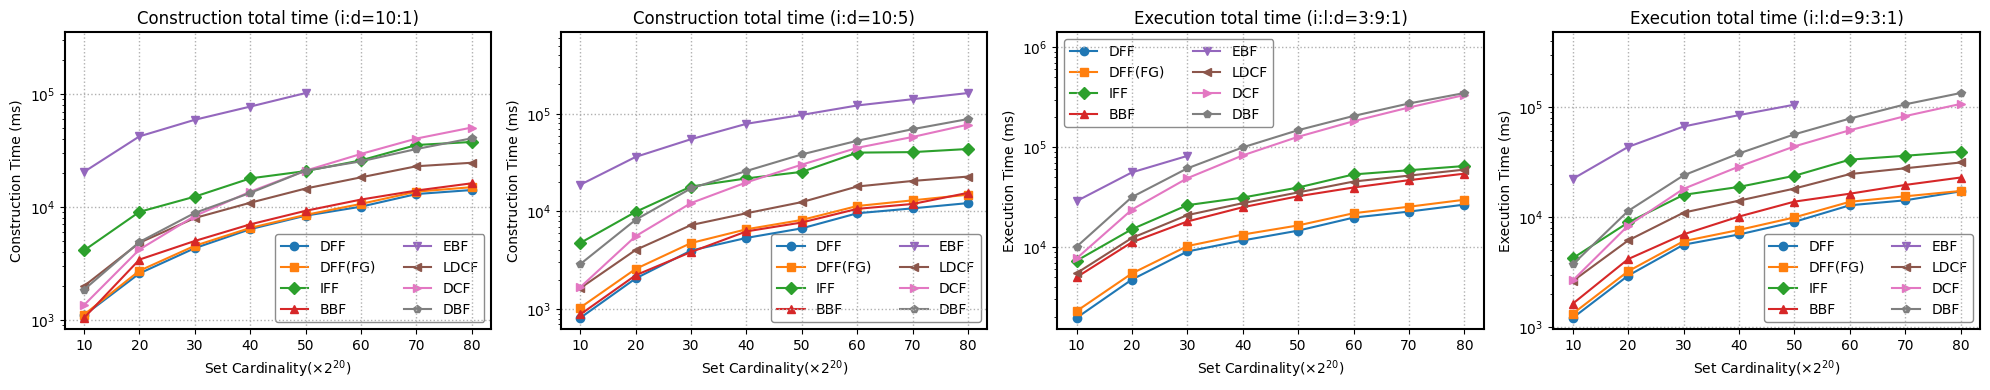

In [12]:
# Construction time
xlabel = "Set Cardinality($\\times2^{" + str(initial_capacity_log2) + "}$)"
ylabel = "Construction Time (ms)"
filenames = ["construction_time_i10d1", "construction_time_i10d5"]

fig, axes = plt.subplots(1, 4, figsize=(20, 4))
for i, (category, df) in enumerate(list(data.items())[10:12]):
    axe = axes[i]
    draw_line_chart(
        axe,
        df,
        xlabel=xlabel,
        ylabel=ylabel,
        yscale="log",
        title=category.replace(" (ms)", ""),
    )
    save_line_chart(
        df, FIGURE_DIR / filenames[i], xlabel=xlabel, ylabel=ylabel, yscale="log"
    )

fig.tight_layout()
fig.show()

# Execution time
xlabel = "Set Cardinality($\\times2^{" + str(initial_capacity_log2) + "}$)"
ylabel = "Execution Time (ms)"
filenames = ["execution_time_i9l3d1", "execution_time_i3l9d1"]

for i, (category, df) in enumerate(list(data.items())[12:14]):
    axe = axes[i + 2]
    draw_line_chart(
        axe,
        df,
        xlabel=xlabel,
        ylabel=ylabel,
        yscale="log",
        title=category.replace(" (ms)", ""),
    )
    save_line_chart(
        df, FIGURE_DIR / filenames[i], xlabel=xlabel, ylabel=ylabel, yscale="log"
    )

fig.tight_layout()
fig.show()

print("Improvement ratio of DFF(B) and DFF(F) over each baseline")
display(
    pd.concat(
        (generate_benchmark_ratio(df) for df in tuple(data.values())[10:12]),
        keys=(
            "construction_time_i10d1",
            "construction_time_i10d5",
        ),
    )
)
display(
    pd.concat(
        (generate_benchmark_ratio(df) for df in tuple(data.values())[12:14]),
        keys=(
            "execution_time_i9l3d1",
            "execution_time_i3l9d1",
        ),
    )
)

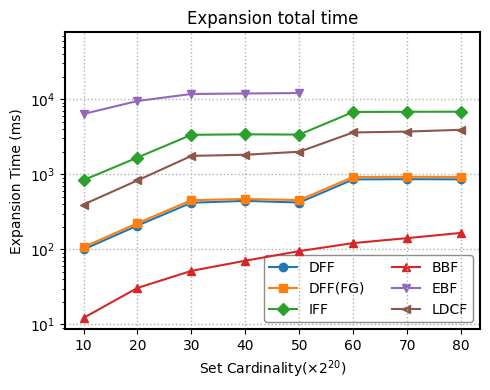

In [13]:
# Expansion time
xlabel = "Set Cardinality($\\times2^{" + str(initial_capacity_log2) + "}$)"
ylabel = "Expansion Time (ms)"

fig, axe = plt.subplots(1, 1, figsize=(5, 4))
category, df = list(data.items())[14]
draw_line_chart(
    axe,
    df,
    xlabel=xlabel,
    ylabel=ylabel,
    yscale="log",
    title=category.replace(" (ms)", ""),
)
save_line_chart(
    df, FIGURE_DIR / "expansion_time", xlabel=xlabel, ylabel=ylabel, yscale="log"
)

fig.tight_layout()
fig.show()

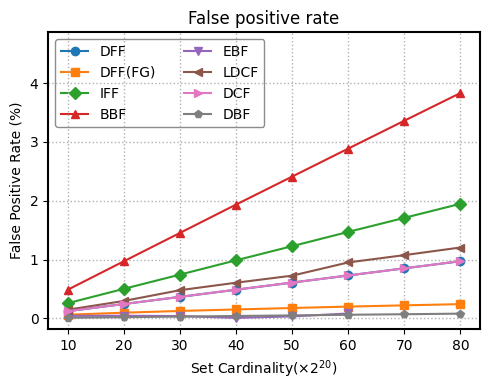

In [14]:
# False positive rate
xlabel = "Set Cardinality($\\times2^{" + str(initial_capacity_log2) + "}$)"
ylabel = "False Positive Rate (%)"

fig, axe = plt.subplots(1, 1, figsize=(5, 4))
category, df = list(data.items())[15]
draw_line_chart(
    axe, df, xlabel=xlabel, ylabel=ylabel, title=category.replace(" (%)", "")
)
save_line_chart(df, FIGURE_DIR / "false_positive_rate", xlabel=xlabel, ylabel=ylabel)

fig.tight_layout()
fig.show()

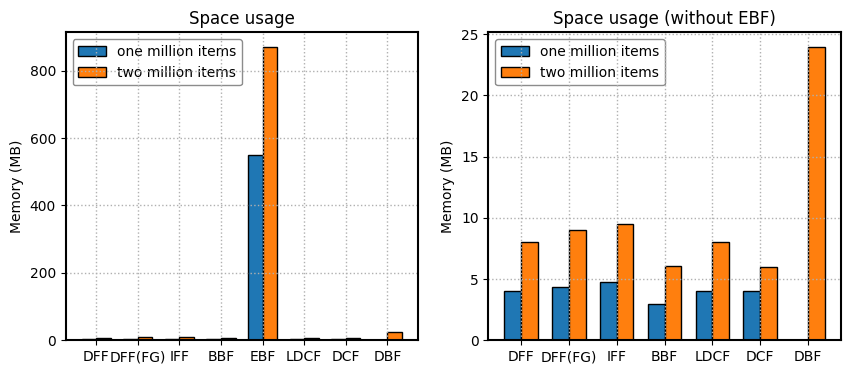

In [15]:
# Space usage
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
category, df = list(data.items())[16]
draw_bar_chart(
    ax1,
    df,
    ylabel="Memory (MB)",
    title=category.replace(" (MB)", ""),
    labels=["one million items", "two million items"],
)

category, df = list(data.items())[16]
df = df.drop(columns=["EBF"])
draw_bar_chart(
    ax2,
    df,
    ylabel="Memory (MB)",
    title=category.replace(" (MB)", "") + " (without EBF)",
    labels=["one million items", "two million items"],
)
save_bar_chart(
    df,
    FIGURE_DIR / "memory_efficiency",
    ylabel="Memory (MB)",
    labels=["one million items", "two million items"],
)

Improvement ratio of DFF(B) and DFF(F) over each baseline


/tmp/ipykernel_532957/3748307799.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  data.loc[:, "DFF"].sum() / data.loc[:, column].sum()
/tmp/ipykernel_532957/3748307799.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  data.loc[:, "DFF(FG)"].sum() / data.loc[:, column].sum()
/tmp/ipykernel_532957/3748307799.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  data.loc[:, "DFF"].sum() / data.loc[:, column].sum()
/tmp/ipykernel_532957/3748307799.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  data.loc[:, "DFF(FG)"].sum() / data.loc[:, column].sum()


IFF       BBF        EBF      LDCF       DCF  DBF
YCSB_insertion DFF      inf  0.081616   84.49789  0.926141  0.538573  inf
               DFF(FG)  inf  0.024768  80.004219  0.824905  0.457707  inf
YCSB_lookup    DFF      inf  1.853744   5.002553  2.948942  2.399161  inf
               DFF(FG)  inf  1.335478   3.912433  2.231777  1.781842  inf

/tmp/ipykernel_532957/3748307799.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  data.loc[:, "DFF"].sum() / data.loc[:, column].sum()
/tmp/ipykernel_532957/3748307799.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  data.loc[:, "DFF(FG)"].sum() / data.loc[:, column].sum()
/tmp/ipykernel_532957/3748307799.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  data.loc[:, "DFF"].sum() / data.loc[:, column].sum()
/tmp/ipykernel_532957/3748307799.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  data.loc[:, "DFF(FG)"].sum() / data.loc[:, column].sum()


IFF       BBF        EBF      LDCF       DCF  \
CAIDA_insertion DFF      5.211864  0.031232  63.298246  0.647932  0.361188   
                DFF(FG)  4.938983 -0.014069  60.473684   0.57554  0.301393   
CAIDA_lookup    DFF      0.957447  1.230228   3.741722  1.731012  1.339537   
                DFF(FG)  0.755022  0.999594   3.251368   1.44859  1.097599   

                         DBF  
CAIDA_insertion DFF      inf  
                DFF(FG)  inf  
CAIDA_lookup    DFF      inf  
                DFF(FG)  inf

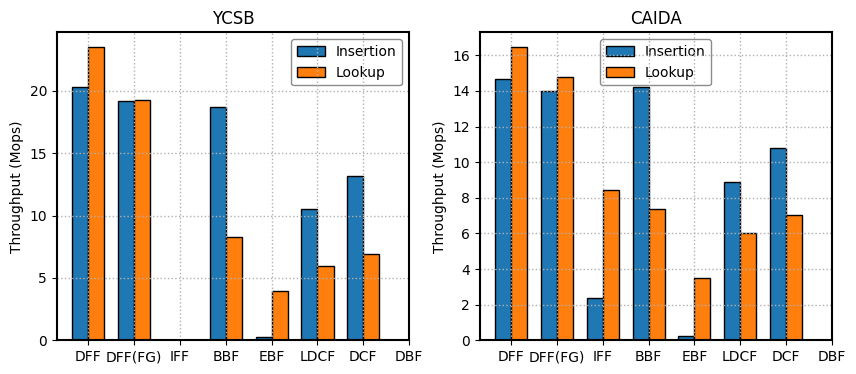

In [16]:
# YCSB
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
df = pd.concat((tuple(data.values())[17], tuple(data.values())[18]))
draw_bar_chart(
    ax1,
    df,
    ylabel="Throughput (Mops)",
    title="YCSB",
    labels=["Insertion", "Lookup"],
)
save_bar_chart(
    df,
    FIGURE_DIR / "YCSB_throughput",
    ylabel="Throughput (Mops)",
    labels=["Insertion", "Lookup"],
)

# CAIDA
df = pd.concat((tuple(data.values())[19], tuple(data.values())[20]))
ax2.set_title("CAIDA")
ax2.set_ylabel("Throughput (Mops)")
draw_bar_chart(
    ax2,
    df,
    ylabel="Throughput (Mops)",
    title="CAIDA",
    labels=["Insertion", "Lookup"],
)
save_bar_chart(
    df,
    FIGURE_DIR / "CAIDA_throughput",
    ylabel="Throughput (Mops)",
    labels=["Insertion", "Lookup"],
)

print("Improvement ratio of DFF(B) and DFF(F) over each baseline")
display(
    pd.concat(
        (generate_benchmark_ratio(df) for df in tuple(data.values())[17:19]),
        keys=("YCSB_insertion", "YCSB_lookup"),
    )
)
display(
    pd.concat(
        (generate_benchmark_ratio(df) for df in tuple(data.values())[19:21]),
        keys=("CAIDA_insertion", "CAIDA_lookup"),
    )
)